# Llama 3.2 1B Evaluation
Ryan Roi Cayas\
2022-22085

In this notebook, we replicate the published scores of the Llama 3.2 1B on the MATH dataset.

## 1. Prerequisites


### 1.1 Load libraries and set-up CUDA

In [1]:
# Import the necessary libraries
import os
import json
import random
import pandas as pd
from tqdm import tqdm

import torch
from torch.utils.data import DataLoader
from transformers import LlamaForCausalLM, PreTrainedTokenizerFast
from datasets import load_dataset # Huggingface datasets (https://huggingface.co/docs/datasets/)
from huggingface_hub import login

In [2]:
# Set-up CUDA device
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
# use a specific GPU
os.environ["CUDA_VISIBLE_DEVICES"]="4"

# Use GPU for inference
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Print the device being used
print(f"Using device: {device}")

# Check the GPU name
if device.type == 'cuda':
    gpu_name = torch.cuda.get_device_name(0)  # 0 because CUDA_VISIBLE_DEVICES=4 means GPU 4 is now 0
    print("Using GPU:", gpu_name)

Using device: cuda
Using GPU: NVIDIA A100-SXM4-40GB


### 1.2 Load the pre-trained tokenizer and model

In [3]:
# Paths to model and tokenizer
model_dir = "../../../../../../llm/llama/Llama-3.2-1B-Instruct"

# Load tokenizer and model
tokenizer = PreTrainedTokenizerFast.from_pretrained(model_dir, padding_side="left")
model = LlamaForCausalLM.from_pretrained(model_dir)

# Set the eos_token as the padding token
tokenizer.pad_token = tokenizer.eos_token

# Move the model to the GPU
model.to(device)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm):

### 1.3 Load the MATH Dataset

In [4]:
math_dataset_test = load_dataset('competition_math', split='test')
math_dataset_test.to_pandas().head()

,problem,level,type,solution
0,How many vertical asymptotes does the graph of...,Level 3,Algebra,The denominator of the rational function facto...
1,What is the positive difference between $120\%...,Level 1,Algebra,One hundred twenty percent of 30 is $120\cdot3...
2,Find $x$ such that $\lceil x \rceil + x = \dfr...,Level 4,Algebra,"First, we note that $x$ must be positive, sinc..."
3,Evaluate $i^5+i^{-25}+i^{45}$.,Level 5,Algebra,We have $i^5 = i^4\cdot i = 1\cdot (i) = i$. ...
4,"If $2^8=4^x$, what is the value of $x$?",Level 1,Algebra,Rewrite $4$ as $2^2$ to find $4^x=2^{2x}$. Si...


In [5]:
# math_dataset_train = load_dataset('competition_math', split='train')
# math_dataset_train.to_pandas().head()

In [6]:
print("Problem:",math_dataset_test[0]['problem'])
print("Level:",math_dataset_test[0]['level'])
print("Type:",math_dataset_test[0]['type'])
print("Solution:",math_dataset_test[0]['solution'])

Problem: How many vertical asymptotes does the graph of $y=\frac{2}{x^2+x-6}$ have?
Level: Level 3
Type: Algebra
Solution: The denominator of the rational function factors into $x^2+x-6=(x-2)(x+3)$. Since the numerator is always nonzero, there is a vertical asymptote whenever the denominator is $0$, which occurs for $x = 2$ and $x = -3$.  Therefore, the graph has $\boxed{2}$ vertical asymptotes.


### 1.4 Load evaluation data from Meta

The evaluation data is publicly released by Meta and is available here: https://huggingface.co/datasets/meta-llama/Llama-3.2-1B-Instruct-evals

We find here the following:
- evaluation config
- full input prompts used by Meta
- parsed answers

In [7]:
# Load token from config.json
with open("../config.json") as f:
    config = json.load(f)

hf_token = config["hf_token"]
login(hf_token)
eval_dataset_FROM_META = load_dataset("meta-llama/Llama-3.2-1B-Instruct-evals", "Llama-3.2-1B-Instruct-evals__math__details")

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /data/students/ryan/.cache/huggingface/token
Login successful


In [8]:
eval_dataset_FROM_META_df = eval_dataset_FROM_META['latest'].to_pandas()
eval_dataset_FROM_META_df.head()

,task_type,task_name,subtask_name,input_question,input_choice_list,input_final_prompts,input_correct_responses,output_prediction_text,output_parsed_answer,output_choice_completions,output_choice_negative_log_likelihoods,output_metrics,is_correct,input_question_hash,input_final_prompts_hash,benchmark_label,eval_config
0,Generative,math_chat_new,None,Find the imaginary part of \[(\cos12^\circ+i\s...,None,[<|start_header_id|>user<|end_header_id|>\n\nS...,[0],[## Step 1: Express the given expression in po...,0,None,None,"{'correct_format': 1.0, 'em': 1.0, 'em_maj1@1'...",True,5a2e4b5ae809e4fe13e8e25fedadc00309a38c663a0872...,[adcde01feac66b5a5a928be8804031ffddcb481ef73e4...,"MATH (4-shot, CoT)","{'max_gen_len': '5120', 'max_prompt_len': '307..."
1,Generative,math_chat_new,None,"What is the least, positive four-digit multipl...",None,[<|start_header_id|>user<|end_header_id|>\n\nS...,[1001],[## Step 1: Determine the smallest four-digit ...,1007,None,None,"{'correct_format': 1.0, 'em': 0.0, 'em_maj1@1'...",False,05be5a24c13a7f03934ca04c01bd595e757234538b3118...,[97745be9a6acd60858e258a46fbd4946e2904dd320c6c...,"MATH (4-shot, CoT)","{'max_gen_len': '5120', 'max_prompt_len': '307..."
2,Generative,math_chat_new,None,What is $(1 + 2 \cdot 3 \cdot 4 \cdot 5) \div ...,None,[<|start_header_id|>user<|end_header_id|>\n\nS...,[11],[## Step 1: Calculate the product inside the p...,21.909...,None,None,"{'correct_format': 1.0, 'em': 0.0, 'em_maj1@1'...",False,fc91c2faca18e68429a3ad12d1edcaf5eaa84183506aaf...,[2a840b3673983db48b20ed473579b710ad1f111764425...,"MATH (4-shot, CoT)","{'max_gen_len': '5120', 'max_prompt_len': '307..."
3,Generative,math_chat_new,None,"Two ropes, 18 meters in length and 24 meters i...",None,[<|start_header_id|>user<|end_header_id|>\n\nS...,[6],[## Step 1: Identify the key constraint\nThe p...,1,None,None,"{'correct_format': 1.0, 'em': 0.0, 'em_maj1@1'...",False,9e87e5f82a292976ff7a0503c803bb2fcbb026b1954d59...,[c7952d5c97db4006ebe8fba59bf41c9caa6dc35c59590...,"MATH (4-shot, CoT)","{'max_gen_len': '5120', 'max_prompt_len': '307..."
4,Generative,math_chat_new,None,"In the diagram below, lines $k$ and $\ell$ are...",None,[<|start_header_id|>user<|end_header_id|>\n\nS...,[60],[## Step 1: The problem provides a diagram wi...,30,None,None,"{'correct_format': 1.0, 'em': 0.0, 'em_maj1@1'...",False,30625ff210cf5a08933c65b91f4ff6b36fa1d03087ea1a...,[857c3d7d39e2cef68320fb00d5271b66676ba06244744...,"MATH (4-shot, CoT)","{'max_gen_len': '5120', 'max_prompt_len': '307..."


In [9]:
# check META's eval_config
eval_dataset_FROM_META_df['eval_config'][0] 

{'max_gen_len': '5120',
 'max_prompt_len': '3072',
 'num_few_shot': '4',
 'num_generations': '1',
 'prompt_fn': "functools.partial(<function jinja_dialog_format at 0x7fe9828b28c0>, template={'prompt': 'Solve the following math problem efficiently and clearly:\\n\\n- For simple problems (2 steps or fewer):\\nProvide a concise solution with minimal explanation.\\n\\n- For complex problems (3 steps or more):\\nUse this step-by-step format:\\n\\n## Step 1: [Concise description]\\n[Brief explanation and calculations]\\n\\n## Step 2: [Concise description]\\n[Brief explanation and calculations]\\n\\n...\\n\\nRegardless of the approach, always conclude with:\\n\\nTherefore, the final answer is: $\\\\boxed{answer}$. I hope it is correct.\\n\\nWhere [answer] is just the final number or expression that solves the problem.\\n\\nProblem: {{ problem }}\\n', 'answer': '{{ solution }}. I hope it is correct.'}, append_gen_prefix=False)",
 'return_logprobs': 'false',
 'seed': '42',
 'temperature': '0.0'

In [10]:
eval_config = {
    'max_gen_len': 5120,
    'max_prompt_len': 3072,
    'num_few_shot': 4,
    'num_generations': 1,
    'prompt_fn': "functools.partial(<function jinja_dialog_format at 0x7fe9828b28c0>, template={'prompt': 'Solve the following math problem efficiently and clearly:\\n\\n- For simple problems (2 steps or fewer):\\nProvide a concise solution with minimal explanation.\\n\\n- For complex problems (3 steps or more):\\nUse this step-by-step format:\\n\\n## Step 1: [Concise description]\\n[Brief explanation and calculations]\\n\\n## Step 2: [Concise description]\\n[Brief explanation and calculations]\\n\\n...\\n\\nRegardless of the approach, always conclude with:\\n\\nTherefore, the final answer is: $\\\\boxed{answer}$. I hope it is correct.\\n\\nWhere [answer] is just the final number or expression that solves the problem.\\n\\nProblem: {{ problem }}\\n', 'answer': '{{ solution }}. I hope it is correct.'}, append_gen_prefix=False)",
    'return_logprobs': False,
    'seed': 42,
    'temperature': 0.0,
    'top_k': 0,
    'top_p': 0.0
}

In [11]:
# set seed for reproducibility
torch.manual_seed(eval_config['seed'])
random.seed(eval_config['seed'])

## 2. Model Inference

### 2.1 Preprocess Data

Here, we use functions provided by Meta in their Llama recipes (based on llm eval harness): https://github.com/meta-llama/llama-recipes/blob/2501f519c7a775e3fab82ff286916671023ca9c6/tools/benchmarks/llm_eval_harness/meta_eval/meta_template/math_hard/utils.py

In [12]:
# %pip install lm_eval

import math_utils
import importlib
importlib.reload(math_utils) 

from math_utils import *

In [13]:
math_dataset_test_processed = process_docs(math_dataset_test) # get numerical answers

In [14]:
# Add the instruction (and sample problems if few shot) before each problem
cot_prompt = "<|start_header_id|>user<|end_header_id|>\n\nSolve the following math problem efficiently and clearly:\n\n- For simple problems (2 steps or fewer):\nProvide a concise solution with minimal explanation.\n\n- For complex problems (3 steps or more):\nUse this step-by-step format:\n\n## Step 1: [Concise description]\n[Brief explanation and calculations]\n\n## Step 2: [Concise description]\n[Brief explanation and calculations]\n\n...\n\nRegardless of the approach, always conclude with:\n\nTherefore, the final answer is: $\\boxed{answer}$. I hope it is correct.\n\nWhere [answer] is just the final number or expression that solves the problem.\n\n"
problems = ["Find the domain of the expression $\\frac{\\sqrt{x-2}}{\\sqrt{5-x}}$.",
            "If $\\det \\mathbf{A} = 2$ and $\\det \\mathbf{B} = 12,$ then find $\\det (\\mathbf{A} \\mathbf{B}).$",
            "Terrell usually lifts two 20-pound weights 12 times. If he uses two 15-pound weights instead, how many times must Terrell lift them in order to lift the same total weight?",
            "If the system of equations\n\n\\begin{align*}\n6x-4y&=a,\\\\\n6y-9x &=b.\n\\end{align*}has a solution $(x, y)$ where $x$ and $y$ are both nonzero, find $\\frac{a}{b},$ assuming $b$ is nonzero."]
solutions = ["## Step 1: Consider the expression inside the first square root\nThe expression inside the first square root is $x-2$, and it must be non-negative. This means that $x-2 \\ge 0$, which simplifies to $x \\ge 2$.\n\n## Step 2: Consider the expression inside the second square root\nThe expression inside the second square root is $5-x$, and it must be non-negative. This means that $5-x \\ge 0$, which simplifies to $x \\le 5$.\n\n## Step 3: Consider the denominator of the expression\nThe denominator of the expression is $\\sqrt{5-x}$, and it cannot be equal to zero. This means that $5-x>0$, which simplifies to $x<5$.\n\n## Step 4: Combine the results from the previous steps\nCombining the results from the previous steps, we have $x \\ge 2$ and $x < 5$. This means that the domain of the expression is $[2,5)$.\n\nThe final answer is: $\\boxed{[2,5)}$. I hope it is correct.",
             "## Step 1:  Understand the properties of determinants\nWe know that the determinant of a product of two matrices is equal to the product of their determinants.\n\n## Step 2: Apply the property to the given matrices\nUsing the property, we can write $\\det (\\mathbf{A} \\mathbf{B}) = (\\det \\mathbf{A})(\\det \\mathbf{B})$.\n\n## Step 3: Substitute the given values\nWe are given that $\\det \\mathbf{A} = 2$ and $\\det \\mathbf{B} = 12$. Substituting these values, we get $\\det (\\mathbf{A} \\mathbf{B}) = (2)(12)$.\n\n## Step 4: Calculate the final answer\nEvaluating the product, we find that $\\det (\\mathbf{A} \\mathbf{B}) = 24$.\n\nThe final answer is: $\\boxed{24}$. I hope it is correct.",
             "## Step 1: Calculate the total weight Terrell lifts with two 20-pound weights\nTerrell lifts two 20-pound weights 12 times, so the total weight he lifts is $2 \\cdot 12 \\cdot 20 = 480$ pounds.\n\n## Step 2: Calculate the total weight Terrell lifts with two 15-pound weights for n times\nIf Terrell lifts two 15-pound weights instead for $n$ times, he will lift a total of $2 \\cdot 15 \\cdot n = 30n$ pounds of weight.\n\n## Step 3: Equate the total weight lifted with 15-pound weights to 480 pounds and solve for n\nEquating the total weight lifted with 15-pound weights to 480 pounds, we can solve for $n$: $30n = 480$.\n\n## Step 4: Solve for n\nTo solve for $n$, divide both sides by 30: $n = \\frac{480}{30}$.\n\n## Step 5: Calculate the value of n\nThe value of $n$ is $\\frac{480}{30} = 16$.\n\nThe final answer is: $\\boxed{16}$. I hope it is correct.",
             "## Step 1: Understand the problem\nWe are given a system of linear equations with two variables, $x$ and $y$, and two constants, $a$ and $b$. Our goal is to find the ratio $\\frac{a}{b}$, assuming $b$ is nonzero.\n\n## Step 2: Multiply the first equation by a suitable factor\nWe multiply the first equation by $-\\frac{3}{2}$ to obtain an equation with the same coefficients for $y$ as the second equation: $$-\\frac{3}{2}(6x-4y)=a\\Rightarrow 6y-9x=-\\frac{3}{2}a.$$\n\n## Step 3: Equate the right-hand sides of the two equations\nSince we know that $6y-9x=b$ from the second equation, we can equate the right-hand sides of the two equations to obtain $$-\\frac{3}{2}a=b.$$\n\n## Step 4: Solve for the ratio $\\frac{a}{b}$\nFinally, we can solve for the ratio $\\frac{a}{b}$ by dividing both sides of the equation by $b$, giving us $$\\frac{a}{b}=-\\frac{2}{3}.$$\n\nThe final answer is: $\\boxed{-\\frac{2}{3}}. I hope it is correct."]

def get_fixed_prompt(cot_prompt, few_shot = False, problems = None, solutions = None):
    "question set contains 'problem', 'solution', 'type', and 'level'"
    if few_shot and (problems is None or solutions is None):
        raise ValueError("Few shot prompts require sample problems and answers")
    
    prompt = cot_prompt

    if few_shot:
        # Concatenate problems and answers with the specified formatting
        for i in range(len(problems)): 
            prompt += f"Problem: {problems[i]}<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n{solutions[i]}<|eot_id|>"
            prompt += cot_prompt

    return prompt

# Get fixed prompt
fixed_prompt = get_fixed_prompt(cot_prompt, few_shot=True, problems=problems, solutions=solutions)
print("Fixed Prompt:\n",fixed_prompt)

Fixed Prompt:
 <|start_header_id|>user<|end_header_id|>

Solve the following math problem efficiently and clearly:

- For simple problems (2 steps or fewer):
Provide a concise solution with minimal explanation.

- For complex problems (3 steps or more):
Use this step-by-step format:

## Step 1: [Concise description]
[Brief explanation and calculations]

## Step 2: [Concise description]
[Brief explanation and calculations]

...

Regardless of the approach, always conclude with:

Therefore, the final answer is: $\boxed{answer}$. I hope it is correct.

Where [answer] is just the final number or expression that solves the problem.

Problem: Find the domain of the expression $\frac{\sqrt{x-2}}{\sqrt{5-x}}$.<|eot_id|><|start_header_id|>assistant<|end_header_id|>

## Step 1: Consider the expression inside the first square root
The expression inside the first square root is $x-2$, and it must be non-negative. This means that $x-2 \ge 0$, which simplifies to $x \ge 2$.

## Step 2: Consider the 

### 2.2 Generate model outputs and evaluate score

In [15]:
generate_config = {
    'max_new_tokens': eval_config['max_gen_len'],
    'num_return_sequences': eval_config['num_generations'],
    'output_scores': eval_config['return_logprobs'],
    'pad_token_id': tokenizer.eos_token_id,
    'do_sample': False,  # since temperature, top_k, top_p are 0
    'top_p': None,
    'temperature': None,
    'top_k': None
}

In [16]:
# Create a DataLoader
batch_size = 32
test_data_loader = DataLoader(math_dataset_test_processed, batch_size=batch_size, shuffle=False, 
                              pin_memory=True if torch.cuda.is_available() else False)

# Create results dict to store final results
results = {'problem': math_dataset_test_processed['problem'], 
            'level': math_dataset_test_processed['level'],
            'type': math_dataset_test_processed['type'],
            'solution': math_dataset_test_processed['solution'],
            'answer': math_dataset_test_processed['answer']}

# Initialize lists to store results
all_generated_texts = []

# Set the model to evaluation mode
model.eval()

with torch.no_grad():
    for batch in tqdm(test_data_loader, total=len(test_data_loader)):
        # Tokenize the batch
        input_prompts = [fixed_prompt + "Problem: " + problem + "<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n" for problem in batch['problem']]
        input_tokenized = tokenizer(input_prompts, return_tensors="pt", padding=True, truncation=False).to(device)

        # Generate output for the batch
        output = model.generate(**input_tokenized, **generate_config)

        # Process generated tokens
        input_lengths = [len(input_tokenized.input_ids[i]) for i in range(len(input_prompts))]
        new_tokens = [output[i][input_lengths[i]:] for i in range(len(input_prompts))]
        new_texts = tokenizer.batch_decode(new_tokens, skip_special_tokens=True)
        all_generated_texts.extend(new_texts)

        # Delete variables in CUDA to free up memory
        del input_tokenized, output

# Add the results back to the dataset
results['generated_text'] = all_generated_texts

# Save the processed dataset

# Create a directory to store the results
output_dir = "outputs"
os.makedirs(output_dir, exist_ok=True)

# Save the results to a file
results_file = os.path.join(output_dir, f"results_4shot.json")
with open(results_file, "w") as f:
    json.dump(results, f)

100%|██████████| 157/157 [25:47:10<00:00, 591.27s/it]   


In [18]:
def evaluate_generated_texts(question_set):
    last_boxed_strings = [last_boxed_only_string(text) for text in question_set['generated_text']]
    generated_answers = [normalize_final_answer(remove_boxed(string)) if string else None for string in last_boxed_strings]

    ground_truth_answers = question_set['answer']

    exact_matches = []
    for i in range(len(generated_answers)):
        if generated_answers[i] is not None:
            exact_match = int(generated_answers[i].strip() == ground_truth_answers[i].strip() or is_equiv(generated_answers[i], ground_truth_answers[i]))
        else:
            exact_match = 0
        exact_matches.append(exact_match)

    question_set['generated_answer'] = generated_answers
    question_set['exact_match'] = exact_matches
    return question_set

# Evaluate the generated texts
results = evaluate_generated_texts(results)

# Save the processed dataset
output_dir = "outputs"
os.makedirs(output_dir, exist_ok=True)
results_file = os.path.join(output_dir, "results_4shot.json")
with open(results_file, "w") as f:
    json.dump(results, f)

In [26]:
results_df = pd.DataFrame(results)
results_df.head()

,problem,level,type,solution,answer,generated_text,generated_answer,exact_match
0,How many vertical asymptotes does the graph of...,Level 3,Algebra,The denominator of the rational function facto...,2,## Step 1: Factor the denominator\nTo find the...,0,0
1,What is the positive difference between $120\%...,Level 1,Algebra,One hundred twenty percent of 30 is $120\cdot3...,10,## Step 1: Calculate 120% of 30\nTo find 120% ...,10,1
2,Find $x$ such that $\lceil x \rceil + x = \dfr...,Level 4,Algebra,"First, we note that $x$ must be positive, sinc...",\dfrac{9}{7},## Step 1: Understand the problem\nWe are give...,\dfrac{23+2f}{14},0
3,Evaluate $i^5+i^{-25}+i^{45}$.,Level 5,Algebra,We have $i^5 = i^4\cdot i = 1\cdot (i) = i$. ...,i,## Step 1: Recall the properties of the imagin...,1,0
4,"If $2^8=4^x$, what is the value of $x$?",Level 1,Algebra,Rewrite $4$ as $2^2$ to find $4^x=2^{2x}$. Si...,4,## Step 1: Rewrite the equation with the same ...,2,0


In [33]:
# Merge the DataFrames based on the matching columns
merged_df = eval_dataset_FROM_META_df.merge(results_df, left_on='input_question', right_on='problem', how='left')

# Drop the redundant 'problem' column from the merged DataFrame
merged_df = merged_df.drop(columns=['problem'])
merged_df.head()

,task_type,task_name,subtask_name,input_question,input_choice_list,input_final_prompts,input_correct_responses,output_prediction_text,output_parsed_answer,output_choice_completions,...,input_final_prompts_hash,benchmark_label,eval_config,level,type,solution,answer,generated_text,generated_answer,exact_match
0,Generative,math_chat_new,None,Find the imaginary part of \[(\cos12^\circ+i\s...,None,[<|start_header_id|>user<|end_header_id|>\n\nS...,[0],[## Step 1: Express the given expression in po...,0,None,...,[adcde01feac66b5a5a928be8804031ffddcb481ef73e4...,"MATH (4-shot, CoT)","{'max_gen_len': '5120', 'max_prompt_len': '307...",Level 3,Precalculus,"Using the sum-to-product formula, we have\n\be...",0,## Step 1: Express the given expression in pol...,0,1
1,Generative,math_chat_new,None,"What is the least, positive four-digit multipl...",None,[<|start_header_id|>user<|end_header_id|>\n\nS...,[1001],[## Step 1: Determine the smallest four-digit ...,1007,None,...,[97745be9a6acd60858e258a46fbd4946e2904dd320c6c...,"MATH (4-shot, CoT)","{'max_gen_len': '5120', 'max_prompt_len': '307...",Level 2,Prealgebra,Dividing 1000 by 7 gives a quotient of 142 and...,1001,## Step 1: Determine the smallest four-digit n...,1001,1
2,Generative,math_chat_new,None,What is $(1 + 2 \cdot 3 \cdot 4 \cdot 5) \div ...,None,[<|start_header_id|>user<|end_header_id|>\n\nS...,[11],[## Step 1: Calculate the product inside the p...,21.909...,None,...,[2a840b3673983db48b20ed473579b710ad1f111764425...,"MATH (4-shot, CoT)","{'max_gen_len': '5120', 'max_prompt_len': '307...",Level 1,Prealgebra,"First, we evaluate the expression in the paren...",11,## Step 1: Calculate the product inside the pa...,21.909...,0
3,Generative,math_chat_new,None,"Two ropes, 18 meters in length and 24 meters i...",None,[<|start_header_id|>user<|end_header_id|>\n\nS...,[6],[## Step 1: Identify the key constraint\nThe p...,1,None,...,[c7952d5c97db4006ebe8fba59bf41c9caa6dc35c59590...,"MATH (4-shot, CoT)","{'max_gen_len': '5120', 'max_prompt_len': '307...",Level 2,Prealgebra,If the two ropes are cut into pieces of length...,6,## Step 1: Identify the key constraint\nThe pr...,21,0
4,Generative,math_chat_new,None,"In the diagram below, lines $k$ and $\ell$ are...",None,[<|start_header_id|>user<|end_header_id|>\n\nS...,[60],[## Step 1: The problem provides a diagram wi...,30,None,...,[857c3d7d39e2cef68320fb00d5271b66676ba06244744...,"MATH (4-shot, CoT)","{'max_gen_len': '5120', 'max_prompt_len': '307...",Level 3,Prealgebra,"[asy]\nsize(200);\npair A = dir(-22)*(0,0);\np...",60,## Step 1: We are given a diagram with two pa...,150,0


In [60]:
# Check exact match per level and type
level_exact_matches = merged_df.groupby('level')['exact_match'].sum()
type_exact_matches = merged_df.groupby('type')['exact_match'].sum()

# Check exact match per level and type
level_exact_matches_meta = merged_df.groupby('level')['is_correct'].sum()
type_exact_matches_meta = merged_df.groupby('type')['is_correct'].sum()


total = len(results_df['level'])
level_total = merged_df.groupby('level')['exact_match'].count()
type_total = merged_df.groupby('type')['exact_match'].count()

level_exact_match_score = level_exact_matches / level_total
type_exact_match_score = type_exact_matches / type_total

level_exact_match_score_meta = level_exact_matches_meta / level_total
type_exact_match_score_meta = type_exact_matches_meta / type_total

# Create table of exact match scores
level_exact_match_scores = pd.DataFrame({
    # 'Level' : level_exact_match_score.index,
    'Personal Score': level_exact_match_score,
    'Meta Score': level_exact_match_score_meta,
})

type_exact_match_scores = pd.DataFrame({
    # 'Type' : type_exact_match_score.index,
    'Personal Score': type_exact_match_score,
    'Meta Score': type_exact_match_score_meta,
})

overall_exact_match_score = sum(merged_df['exact_match']) / total
overall_exact_match_score_meta = sum(merged_df['is_correct']) / total

print("Level Exact Match Scores:")
print(level_exact_match_scores)
print("\nType Exact Match Scores:")
print(type_exact_match_scores)

print("\nOverall Exact Match Score:", overall_exact_match_score)
print("Overall Exact Match Score Meta:", overall_exact_match_score_meta)

Level Exact Match Scores:
         Personal Score  Meta Score
level                              
Level 1        0.663616    0.661327
Level 2        0.495526    0.483221
Level 3        0.359859    0.352785
Level 4        0.224053    0.222405
Level 5        0.092145    0.099698

Type Exact Match Scores:
                        Personal Score  Meta Score
type                                              
Algebra                       0.437237    0.442291
Counting & Probability        0.276371    0.280591
Geometry                      0.254697    0.254697
Intermediate Algebra          0.143965    0.140642
Number Theory                 0.250000    0.233333
Prealgebra                    0.448909    0.442021
Precalculus                   0.194139    0.190476

Overall Exact Match Score: 0.3068
Overall Exact Match Score Meta: 0.3044


### 2.3 Evaluate model with 0-shot CoT prompt

In [42]:
cot_prompt_only = get_fixed_prompt(cot_prompt, few_shot=False)

# Create a DataLoader
batch_size = 32
test_data_loader = DataLoader(math_dataset_test_processed, batch_size=batch_size, shuffle=False, 
                              pin_memory=True if torch.cuda.is_available() else False)

# Create results dict to store final results
results_2 = {'problem': math_dataset_test_processed['problem'], 
            'level': math_dataset_test_processed['level'],
            'type': math_dataset_test_processed['type'],
            'solution': math_dataset_test_processed['solution'],
            'answer': math_dataset_test_processed['answer']}

# Initialize lists to store results
all_generated_texts = []

# Set the model to evaluation mode
model.eval()

with torch.no_grad():
    for batch in tqdm(test_data_loader, total=len(test_data_loader)):
        # Tokenize the batch
        input_prompts = [cot_prompt_only + "Problem: " + problem + "<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n" for problem in batch['problem']]
        input_tokenized = tokenizer(input_prompts, return_tensors="pt", padding=True, truncation=False).to(device)

        # Generate output for the batch
        output = model.generate(**input_tokenized, **generate_config)

        # Process generated tokens
        input_lengths = [len(input_tokenized.input_ids[i]) for i in range(len(input_prompts))]
        new_tokens = [output[i][input_lengths[i]:] for i in range(len(input_prompts))]
        new_texts = tokenizer.batch_decode(new_tokens, skip_special_tokens=True)
        all_generated_texts.extend(new_texts)

        # Delete variables in CUDA to free up memory
        del input_tokenized, output

# Add the results back to the dataset
results_2['generated_text'] = all_generated_texts

# Save the processed dataset

# Create a directory to store the results
output_dir = "outputs"
os.makedirs(output_dir, exist_ok=True)

# Save the results to a file
results_2_file = os.path.join(output_dir, f"results_0shot.json")
with open(results_2_file, "w") as f:
    json.dump(results_2, f)

100%|██████████| 157/157 [21:20:33<00:00, 489.39s/it]  


In [43]:
# Evaluate the generated texts
results_2 = evaluate_generated_texts(results_2)

# Save the processed dataset
output_dir = "outputs"
os.makedirs(output_dir, exist_ok=True)
results_2_file = os.path.join(output_dir, "results_0shot.json")
with open(results_2_file, "w") as f:
    json.dump(results_2, f)

In [59]:
# Merge the DataFrames based on the matching columns
results_df_2 = pd.DataFrame(results_2)
merged_df_2 = eval_dataset_FROM_META_df.merge(results_df_2, left_on='input_question', right_on='problem', how='left')
merged_df_2 = merged_df_2.drop(columns=['problem'])

# Check exact match per level and type
level_exact_matches = merged_df_2.groupby('level')['exact_match'].sum()
type_exact_matches = merged_df_2.groupby('type')['exact_match'].sum()

# Check exact match per level and type
level_exact_matches_meta = merged_df_2.groupby('level')['is_correct'].sum()
type_exact_matches_meta = merged_df_2.groupby('type')['is_correct'].sum()

total = len(results_df_2['level'])
level_total = merged_df_2.groupby('level')['exact_match'].count()
type_total = merged_df_2.groupby('type')['exact_match'].count()

level_exact_match_score = level_exact_matches / level_total
type_exact_match_score = type_exact_matches / type_total

level_exact_match_score_meta = level_exact_matches_meta / level_total
type_exact_match_score_meta = type_exact_matches_meta / type_total

# Create table of exact match scores
level_exact_match_scores = pd.DataFrame({
    # 'Level' : level_exact_match_score.index,
    'Personal Score': level_exact_match_score,
    'Meta Score': level_exact_match_score_meta,
})

type_exact_match_scores = pd.DataFrame({
    # 'Type' : type_exact_match_score.index,
    'Personal Score': type_exact_match_score,
    'Meta Score': type_exact_match_score_meta,
})

overall_exact_match_score = sum(merged_df_2['exact_match']) / total
overall_exact_match_score_meta = sum(merged_df_2['is_correct']) / total

print("Level Exact Match Scores:")
print(level_exact_match_scores)
print("\nType Exact Match Scores:")
print(type_exact_match_scores)

print("\nOverall Exact Match Score:", overall_exact_match_score)
print("Overall Exact Match Score Meta:", overall_exact_match_score_meta)

Level Exact Match Scores:
         Personal Score  Meta Score
level                              
Level 1        0.654462    0.661327
Level 2        0.476510    0.483221
Level 3        0.367816    0.352785
Level 4        0.224876    0.222405
Level 5        0.117069    0.099698

Type Exact Match Scores:
                        Personal Score  Meta Score
type                                              
Algebra                       0.471778    0.442291
Counting & Probability        0.259494    0.280591
Geometry                      0.267223    0.254697
Intermediate Algebra          0.152824    0.140642
Number Theory                 0.229630    0.233333
Prealgebra                    0.442021    0.442021
Precalculus                   0.179487    0.190476

Overall Exact Match Score: 0.3112
Overall Exact Match Score Meta: 0.3044


## 3. Overall Analysis

This section can be ran separately.

In [2]:
import json
import os
import pandas as pd

from huggingface_hub import login
from datasets import load_dataset

# Load token from config.json
with open("../config.json") as f:
    config = json.load(f)

hf_token = config["hf_token"]
login(hf_token)
eval_dataset_FROM_META = load_dataset("meta-llama/Llama-3.2-1B-Instruct-evals", "Llama-3.2-1B-Instruct-evals__math__details")

eval_dataset_FROM_META_df = eval_dataset_FROM_META['latest'].to_pandas()
eval_dataset_FROM_META_df.head()

# Load saved results
output_dir = "outputs"

results_0shot_file = os.path.join(output_dir, "results_0shot.json")
with open(results_0shot_file, "r") as f:
   results_0shot = json.load(f)

results_4shot_file = os.path.join(output_dir, "results_4shot.json")
with open(results_4shot_file, "r") as f:
   results_4shot = json.load(f)

# combine personal results with Meta's
overall_results = pd.DataFrame(data={"problem": results_0shot['problem'],
                                     "level": results_0shot['level'],
                                     "type": results_0shot['type'],
                                     "ground_truth": results_0shot['answer'],
                                     "0shot_solution": results_0shot['generated_text'],
                                     "4shot_solution": results_4shot['generated_text'],
                                     "0shot_answer": results_0shot['generated_answer'],
                                     "4shot_answer": results_4shot['generated_answer'],
                                     "0shot_em": results_0shot['exact_match'],
                                     "4shot_em": results_4shot['exact_match'],
                                     }
                                     )

eval_dataset_FROM_META_df_2 = eval_dataset_FROM_META_df[["input_question", "output_prediction_text", "output_parsed_answer", "is_correct"]]
eval_dataset_FROM_META_df_2.loc[:, 'is_correct'] = eval_dataset_FROM_META_df_2['is_correct'].astype(int)
eval_dataset_FROM_META_df_2 = eval_dataset_FROM_META_df_2.rename(columns={"input_question": "problem", "output_prediction_text": "meta_solution", "output_parsed_answer": "meta_answer", "is_correct": "meta_em"})

overall_results = pd.merge(overall_results, eval_dataset_FROM_META_df_2, on="problem")
overall_results = overall_results[["problem", "level", "type", "0shot_solution", "4shot_solution", "meta_solution", "ground_truth", "0shot_answer", "4shot_answer", "meta_answer", "0shot_em", "4shot_em", "meta_em"]]
overall_results.head()

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /data/students/ryan/.cache/huggingface/token
Login successful


/tmp/ipykernel_773957/3856713795.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1 0 0 ... 1 1 1]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  eval_dataset_FROM_META_df_2.loc[:, 'is_correct'] = eval_dataset_FROM_META_df_2['is_correct'].astype(int)


,problem,level,type,0shot_solution,4shot_solution,meta_solution,ground_truth,0shot_answer,4shot_answer,meta_answer,0shot_em,4shot_em,meta_em
0,How many vertical asymptotes does the graph of...,Level 3,Algebra,## Step 1: Factor the denominator\nThe denomin...,## Step 1: Factor the denominator\nTo find the...,[## Step 1: Factor the denominator\nTo find th...,2,-3,0,2,0,0,1
1,What is the positive difference between $120\%...,Level 1,Algebra,## Step 1: Calculate 120% of 30\nTo find 120% ...,## Step 1: Calculate 120% of 30\nTo find 120% ...,[## Step 1: Calculate 120% of 30\nTo find 120%...,10,10,10,10,1,1,1
2,Find $x$ such that $\lceil x \rceil + x = \dfr...,Level 4,Algebra,## Step 1: Understand the problem\nWe need to ...,## Step 1: Understand the problem\nWe are give...,[## Step 1: Understand the problem\nWe are giv...,\dfrac{9}{7},\dfrac{2}{7},\dfrac{23+2f}{14},1-n,0,0,0
3,Evaluate $i^5+i^{-25}+i^{45}$.,Level 5,Algebra,"## Step 1: Evaluate $i^5$\nSince $i^2 = -1$, w...",## Step 1: Recall the properties of the imagin...,[## Step 1: Recall the properties of the imagi...,i,i,1,1,1,0,0
4,"If $2^8=4^x$, what is the value of $x$?",Level 1,Algebra,## Step 1: Express both sides of the equation ...,## Step 1: Rewrite the equation with the same ...,[## Step 1: Rewrite the equation with the same...,4,4,2,2,1,0,0


In [5]:
# Check None values
overall_results.isnull().sum()

problem             0
level               0
type                0
0shot_solution      0
4shot_solution      0
meta_solution       0
ground_truth        0
0shot_answer      699
4shot_answer      345
meta_answer         0
0shot_em            0
4shot_em            0
meta_em             0
dtype: int64

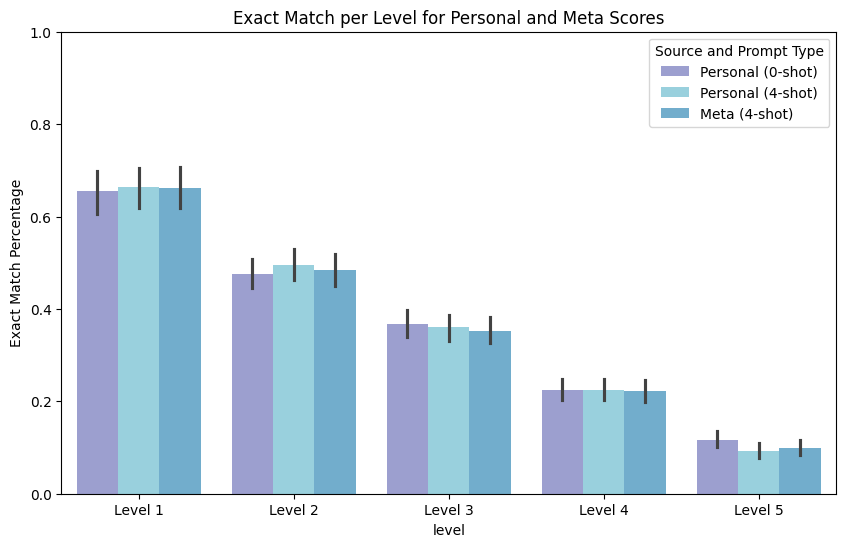

In [3]:
# plot exact match per level for 0-shot 4-shot and meta scores
import matplotlib.pyplot as plt
import seaborn as sns

# Melt the DataFrame to long format
melted_results = pd.melt(overall_results, id_vars=['level'], value_vars=['0shot_em', '4shot_em', 'meta_em'],
                         var_name='Source and Prompt Type', value_name='Exact Match Percentage')

# Rename the shot types for better readability
melted_results['Source and Prompt Type'] = melted_results['Source and Prompt Type'].replace({
    '0shot_em': 'Personal (0-shot)',
    '4shot_em': 'Personal (4-shot)',
    'meta_em': 'Meta (4-shot)'
})

# Define a custom color palette
custom_palette = {
    'Personal (0-shot)': '#9397d8',  # Purple
    'Personal (4-shot)': '#8ed7e8',  # Sky Blue
    'Meta (4-shot)': '#63b1db'      # Blue
}

# Ensure the levels are ordered from 1 to 5
melted_results['level'] = pd.Categorical(melted_results['level'], categories=['Level 1', 'Level 2', 'Level 3', 'Level 4', 'Level 5'], ordered=True)

# Plot the combined bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='level', y='Exact Match Percentage', hue='Source and Prompt Type', data=melted_results, palette=custom_palette)
plt.ylim(0, 1)
plt.title('Exact Match per Level for Personal and Meta Scores')
plt.show()

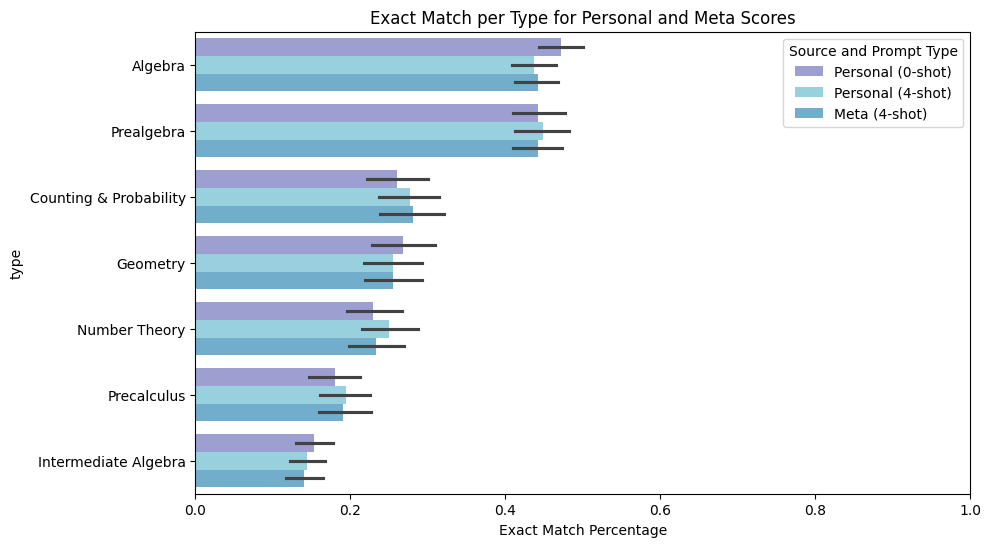

In [4]:
# Melt the DataFrame to long format
melted_results = pd.melt(overall_results, id_vars=['type'], value_vars=['0shot_em', '4shot_em', 'meta_em'],
                         var_name='Source and Prompt Type', value_name='Exact Match Percentage')

# Rename the shot types for better readability
melted_results['Source and Prompt Type'] = melted_results['Source and Prompt Type'].replace({
    '0shot_em': 'Personal (0-shot)',
    '4shot_em': 'Personal (4-shot)',
    'meta_em': 'Meta (4-shot)'
})

# Define a custom color palette
custom_palette = {
    'Personal (0-shot)': '#9397d8',  # Purple
    'Personal (4-shot)': '#8ed7e8',  # Sky Blue
    'Meta (4-shot)': '#63b1db'      # Blue
}

# Order categories
melted_results['type'] = pd.Categorical(melted_results['type'], categories=['Algebra', 'Prealgebra', 'Counting & Probability', 'Geometry', 'Number Theory', 'Precalculus', 'Intermediate Algebra'], ordered=True)


# Plot the combined bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Exact Match Percentage', y='type', hue='Source and Prompt Type', data=melted_results, palette=custom_palette)
plt.xlim(0, 1)
plt.title('Exact Match per Type for Personal and Meta Scores')
# plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels

plt.show()